# 시계열 예측 - 자전거
- 선형 모델
- ARIMA
- prophet

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from fbprophet import Prophet


import warnings
warnings.simplefilter('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터 다운로드

In [26]:
bike = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
print(bike.shape)
bike[:3]

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 자전거 대여수 (시계열 데이터)

In [31]:
df = bike[["datetime","count"]]
df[:3]

,datetime,count
0,2011-01-01 00:00:00,16
1,2011-01-01 01:00:00,40
2,2011-01-01 02:00:00,32


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  10886 non-null  datetime64[ns]
 1   count     10886 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 170.2 KB


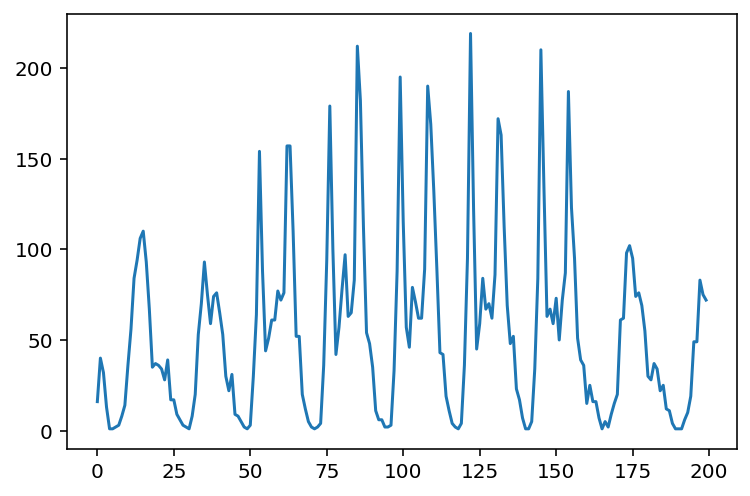

In [33]:
plt.plot(df["count"][:200])

In [29]:
# df["datetime"] = pd.to_datetime(df["datetime"])

## 시각화 함수

In [40]:
# 실제값과 예측치 비교
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

In [147]:
def scatter_errors(y_test, y_pred):
    error = abs(y_test - y_pred)
    plt.scatter(y_test, error, s=2)

# 선형 모델

In [42]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

((7620,), (3266,))

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [43]:
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

## 적절한 n_steps_in 찾기

In [44]:
lr= LinearRegression()
n_steps_out = 1
for n_steps_in in range(1,24*15,24):
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(3))

337 0.662
337 0.866
337 0.877
337 0.883
337 0.886
337 0.89
337 0.897
337 0.902
337 0.901
337 0.902
337 0.902
337 0.901
337 0.901
337 0.901
337 0.901


### 최적값 선택

337 0.902


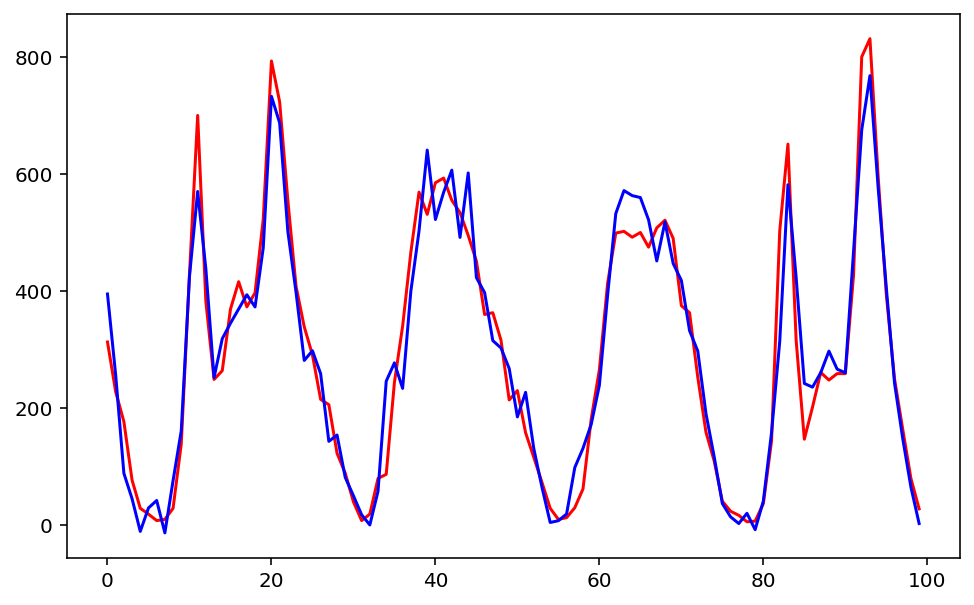

In [45]:
n_steps_in = 10*24
n_steps_out = 1
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

- 1시간 후를 예측했으므로 정확하다

MAE= 47.253
rmse= 67.918
max= 453.003


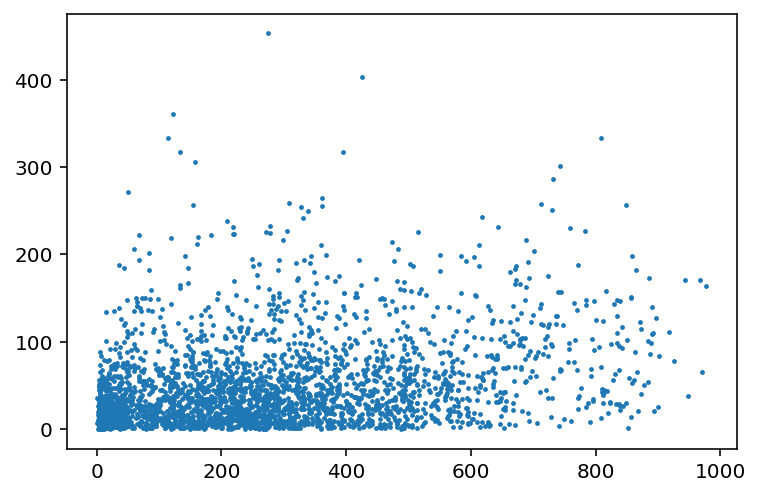

In [23]:
scatter_errors(y_test, y_pred)

## 미래 예측

In [46]:
lr = LinearRegression()
n_steps_in = 10*24
n_futures = [1,24, 24*7, 24*7*2, 24*7*3]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))

1 : 0.902
24 : 0.767
168 : 0.727
336 : 0.679
504 : 0.596


## 최적값 선택 in, out

In [47]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

168 , 0.727


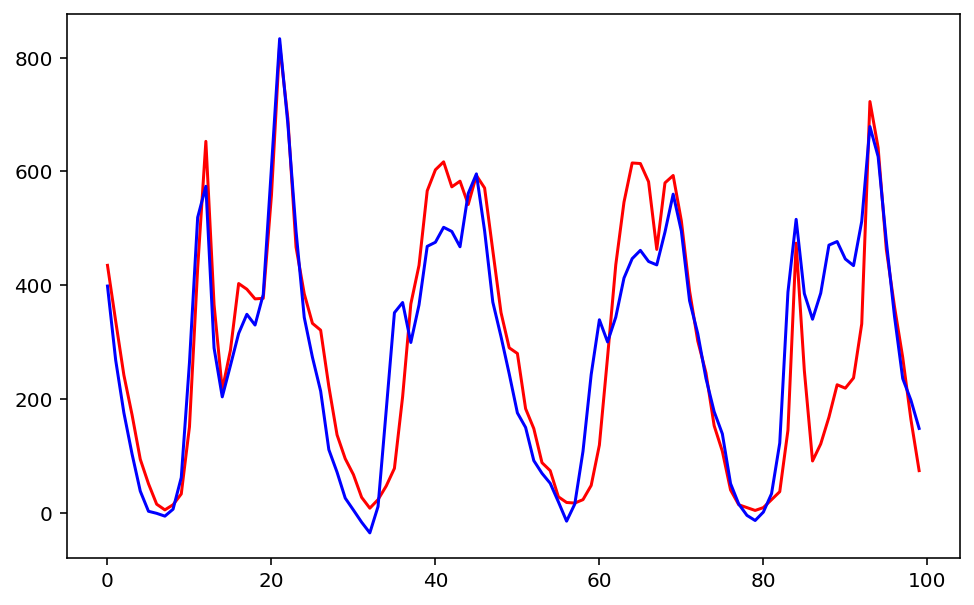

In [48]:
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

MAE= 80.656
rmse= 113.005
max= 565.626


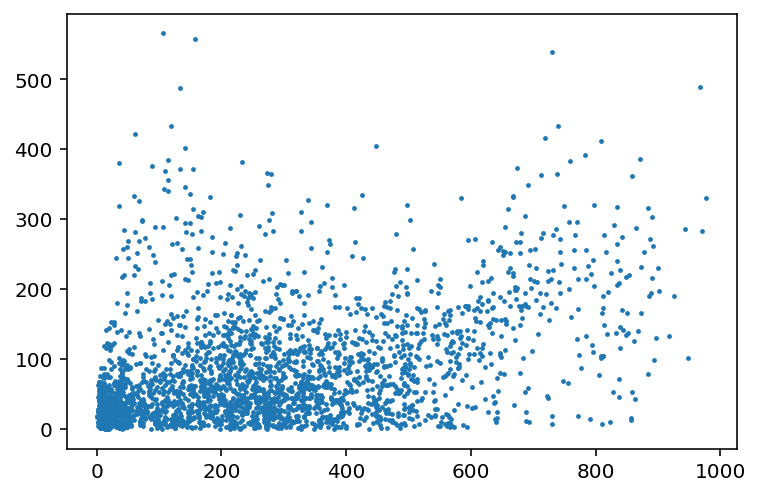

In [49]:
scatter_errors(y_test, y_pred)

# Prophet

In [62]:
df.columns = ['ds', 'y']
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [65]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [66]:
df['ds'].min(), df['ds'].max(), 

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [88]:
from datetime import datetime
from pandas import date_range

##  훈련 및 검증 

In [197]:
# cut = np.int((len(df)*0.7))
# test 기간 = 1 주일 (24*7)
train = df[:-24*7]
test = df[-24*7:]
train.shape, test.shape

((10718, 2), (168, 2))

In [198]:
future_test = test["ds"]
future_test[:3]

10718   2012-12-13 00:00:00
10719   2012-12-13 01:00:00
10720   2012-12-13 02:00:00
Name: ds, dtype: datetime64[ns]

In [199]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [200]:
future_test = pd.DataFrame(future_test)
future_test.columns = ['ds']
future_test[:3]

,ds
10718,2012-12-13 00:00:00
10719,2012-12-13 01:00:00
10720,2012-12-13 02:00:00


In [201]:
forecast = model.predict(future_test)
y_pred = forecast['yhat'].values
y_pred.shape

(168,)

In [202]:
y_test = test.y.values
y_test.shape

(168,)

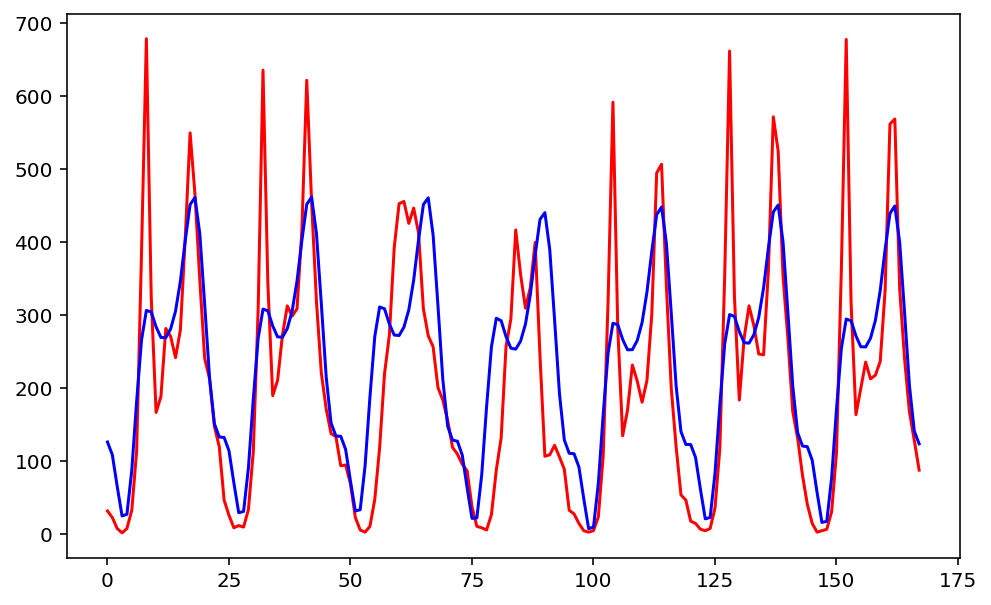

In [203]:
plot_y_pred(y_test, y_pred)

## 향후 1개월 기간 예측

In [204]:
future = pd.date_range(start='2013-01-01', end='2013-01-20', 
                       freq='H').to_frame(index=False, name='ds')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01 00:00:00,117.935158,-24.013207,260.072741
1,2013-01-01 01:00:00,100.169715,-42.913137,240.605364
2,2013-01-01 02:00:00,56.798069,-83.200518,204.394563
3,2013-01-01 03:00:00,16.128398,-137.535738,154.780527
4,2013-01-01 04:00:00,18.066271,-130.610655,158.830910


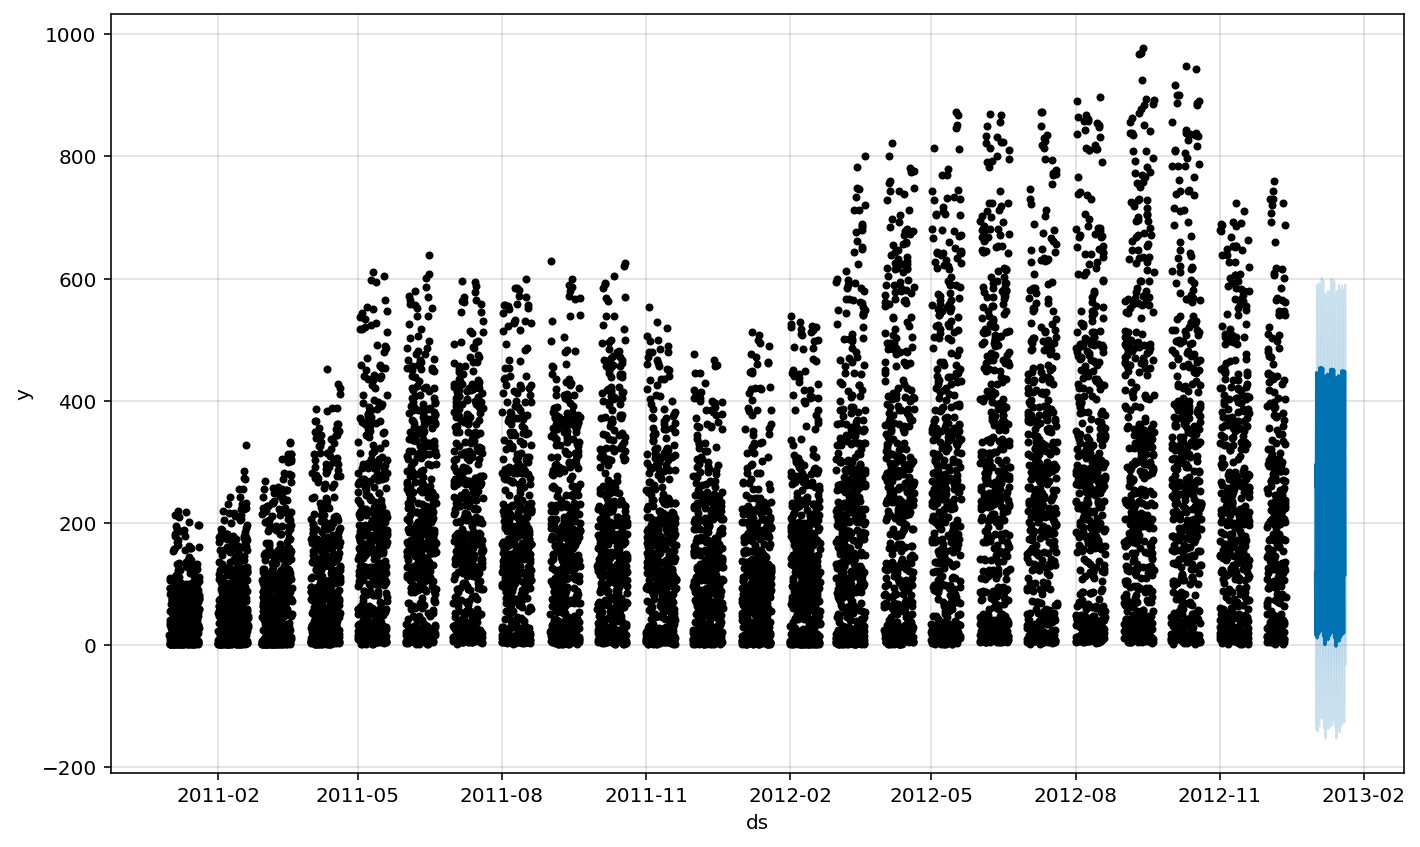

In [205]:
model.plot(forecast); plt.show()

# Datetime  표시 (xtick)

In [193]:
import datetime
import matplotlib.dates as mdates
import matplotlib.units as munits

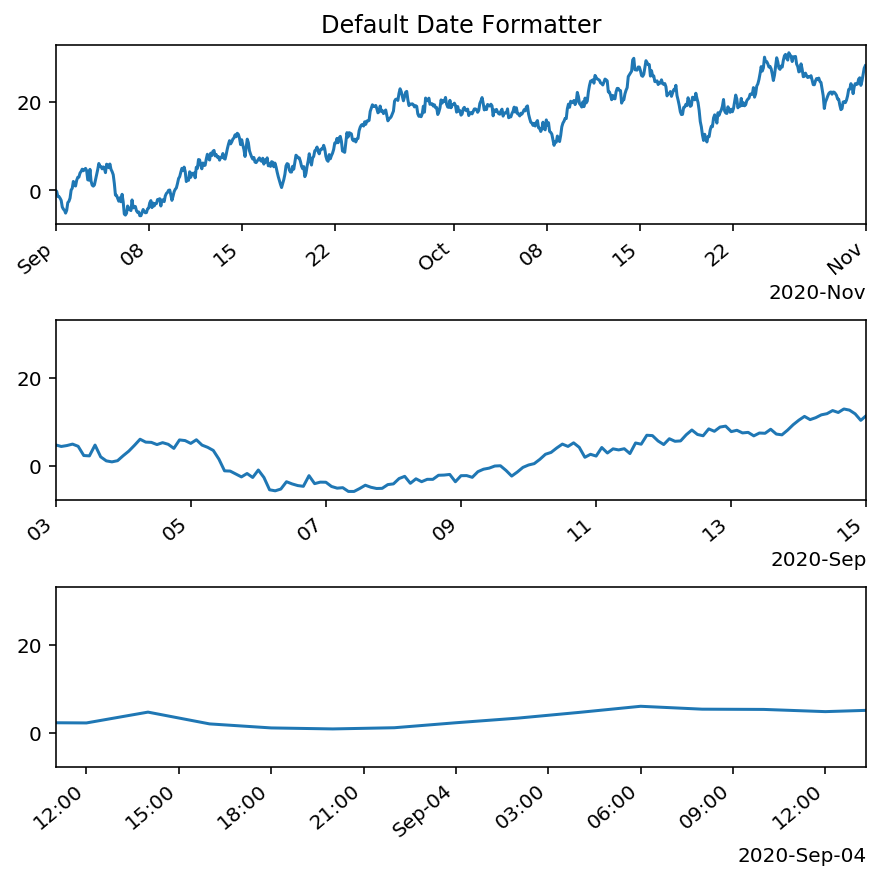

In [194]:
base = datetime.datetime(2020, 9, 1)
dates = np.array([base + datetime.timedelta(hours=(2 * i))
                  for i in range(732)])
N = len(dates)
np.random.seed(9)
y = np.cumsum(np.random.randn(N))

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(6, 6))
lims = [(np.datetime64('2020-09'), np.datetime64('2020-11')),
        (np.datetime64('2020-09-03'), np.datetime64('2020-09-15')),
        (np.datetime64('2020-09-03 11:00'), np.datetime64('2020-09-04 13:20'))]
for nn, ax in enumerate(axs):
    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
    # rotate_labels...
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')
axs[0].set_title('Default Date Formatter')
plt.show()

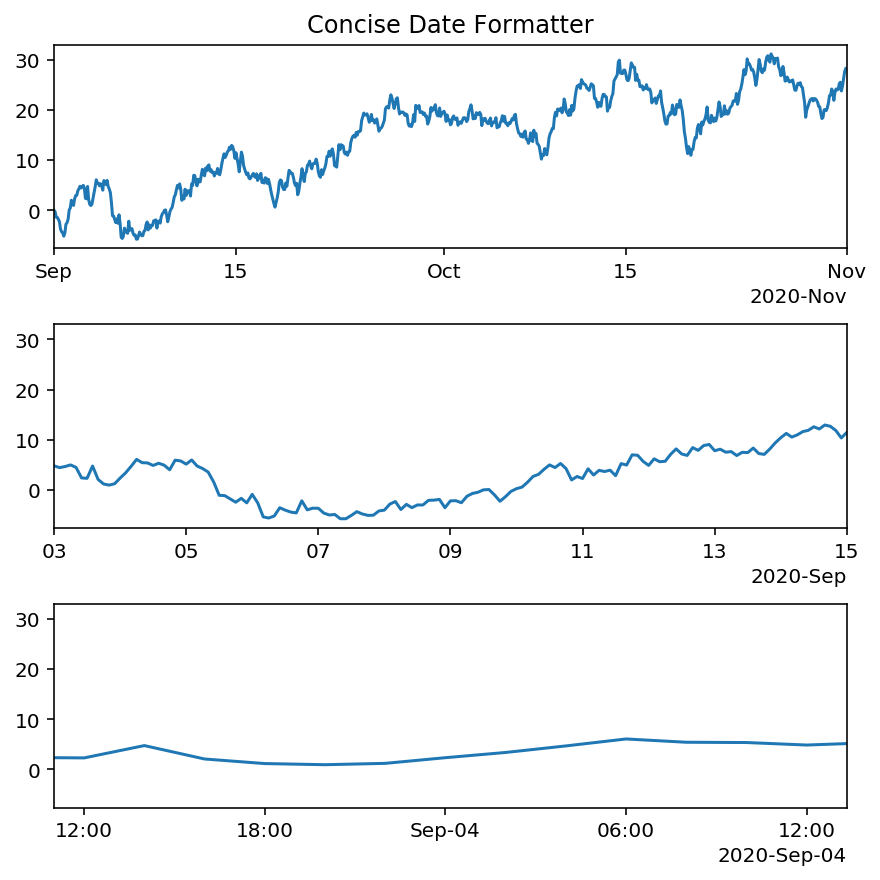

In [195]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(6, 6))
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
axs[0].set_title('Concise Date Formatter')
plt.show()

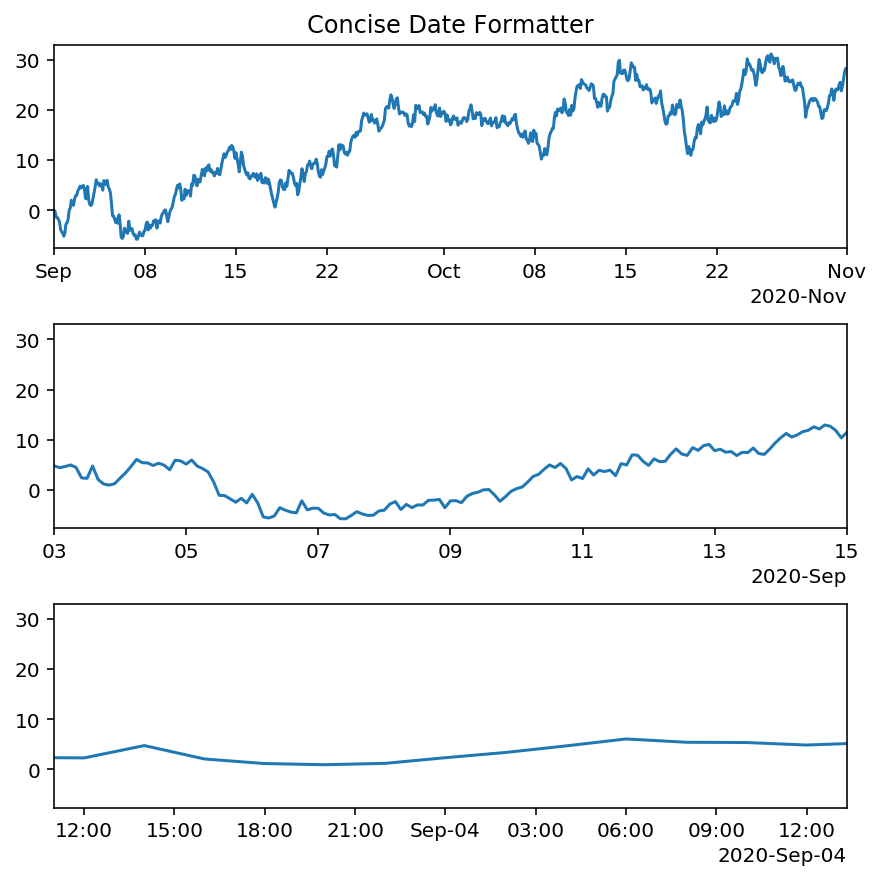

In [196]:
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig, axs = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
for nn, ax in enumerate(axs):
    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
axs[0].set_title('Concise Date Formatter')

plt.show()